In [1]:
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Any, Literal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import magnetopy as mp

DATA_PATH = Path("../../tests/data/")

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Field (T)', ylabel='Magnetization ($N_A \\cdot \\mu_B$)'>)

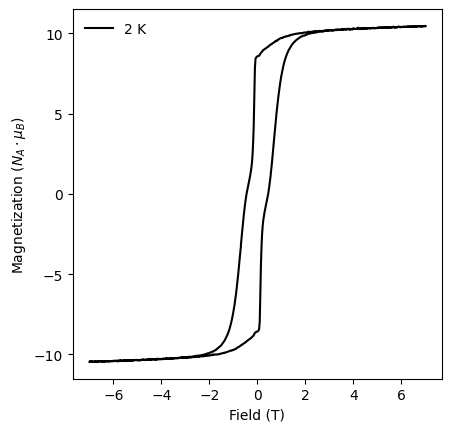

In [2]:
dset1 = mp.Magnetometry(DATA_PATH / "dataset1")
mvsh = dset1.get_mvsh(2)
mvsh.plot()

(-15000.0, 15000.0)

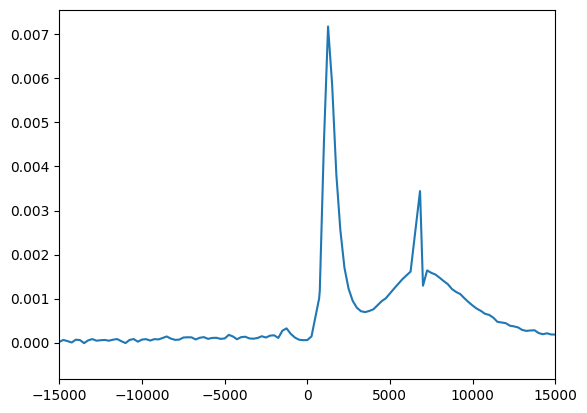

In [3]:
df = mvsh.simplified_data("forward").copy()
df['dmdh'] = np.gradient(df['moment'], df['field'])

fig, ax = plt.subplots()
ax.plot(df['field'][2:-2], df['dmdh'][2:-2])
ax.set_xlim(-15000, 15000)

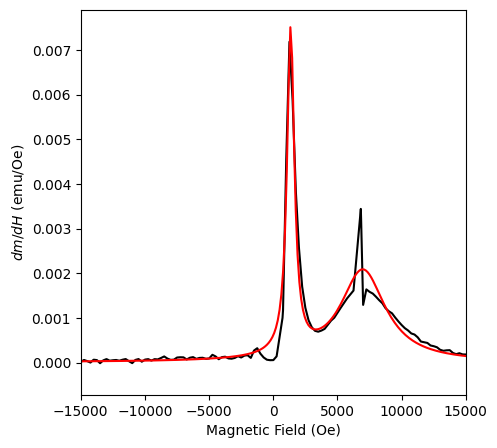

In [4]:
results = mp.fit_cauchy_pdf(df['field'][2:-2], df['dmdh'][2:-2], 2)

fig, ax = mp.plot_cauchy_pdf(df['field'], df['dmdh'], results)

# df['sim'] = results.simulate_data(df['field'])

# fig, ax = plt.subplots()
# ax.plot(df['field'], df['dmdh'], label="data")
# ax.plot(df['field'], df['sim'], label="sim")
# ax.legend()
# ax.set_xlim(-15000, 15000)
# ax.set_ylim(-0.001, 0.015)

In [17]:
# integrate dmdh
df['calc_moment'] = np.cumsum(df['dmdh'] * np.gradient(df['field']))
calc_saturation = 0.5 * (df['calc_moment'].max() - df['calc_moment'].min())

fitting_args = mp.CauchyFittingArgs(
    [
        mp.CauchyParams(
            m_s = (calc_saturation/2, 0, 10),
            h_c = (0, -5000, 5000),
            gamma = (1000, 0, 10000)
        ),
        mp.CauchyParams(
            m_s = (calc_saturation/2, 0, 10),
            h_c = (7500, 5000, 10000),
            gamma = (1000, 0, 10000)
        ), 
    ]
)

results = mp.fit_cauchy_pdf(df['field'][2:-2], df['dmdh'][2:-2], fitting_args)
results.as_dict()

{'terms': [{'m_s': 3.8931198778705793,
   'm_s_err': 0.08424685061106676,
   'h_c': 1356.812317447192,
   'h_c_err': 6.622551486404807,
   'gamma': 1361.3173579523398,
   'gamma_err': 41.21730649594005},
  {'m_s': 6.902987686072628,
   'm_s_err': 0.22936450393648433,
   'h_c': 6977.446003093358,
   'h_c_err': 62.5780140486613,
   'gamma': 8549.012676165925,
   'gamma_err': 375.97054419626835}],
 'chi_pd': 6.6673981936919484e-06,
 'chi_pd_err': 7.093029963530422e-06,
 'chi_squared': 1.2765172774471527e-05,
 'reduced_chi_squared': 2.3125312997231027e-08,
 'm_s_unit': 'unknown',
 'h_c_unit': 'unknown',
 'gamma_unit': 'unknown',
 'chi_pd_unit': 'unknown',
 '_class_': 'CauchyAnalysisResults'}

In [18]:
x_range = (df['field'].min(), df['field'].max())
y_max = df['dmdh'].max()
df['input'] = fitting_args.generate_data(df['field'])
df['sim'] = results.simulate_data(df['field'])

(-0.001, 0.015)

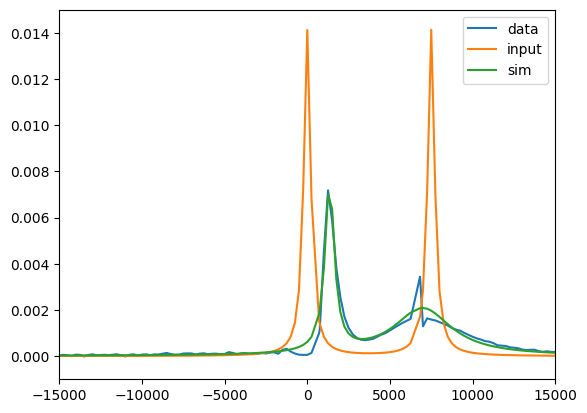

In [25]:
fig, ax = plt.subplots()
ax.plot(df['field'], df['dmdh'], label="data")
ax.plot(df['field'], df['input'], label="input")
ax.plot(df['field'], df['sim'], label="sim")
ax.legend()
ax.set_xlim(-15000, 15000)
ax.set_ylim(-0.001, 0.015)